In [14]:
import os
os.environ['TRANSFORMERS_OFFLINE'] = '1'
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from models import VITForClassification

model = VITForClassification.from_pretrained('../ckpts/VIT').cuda()
model.vit.apply_attention_map()

Model Parameters: 6,334,976
Model Parameters: 6,334,976
Attention_map is now supported! This may cause unnecessary memory consumption if you are not conducting a visualization.


In [88]:
DATA_IDX = 6
LAYER_IDX = -1

In [89]:
transform = T.Compose([T.ToTensor(), T.Normalize([0.5], [0.5])])
dataset = torchvision.datasets.MNIST('../data/MNIST', train=False, transform=transform, download=True)
image = dataset[DATA_IDX][0].cuda().unsqueeze(0)
raw_image = image.cpu().permute(0, 2, 3, 1).squeeze().numpy() * 0.5 + 0.5

In [90]:
with torch.no_grad():
    output = model(image)
print('Prediction:', torch.argmax(output.logits, dim=1).item())

Prediction: 4


In [91]:
attn_score = model.vit.encoder.encoder_blocks[LAYER_IDX].self_attention.attention_weights.mean(dim=1).cpu().detach()
attn_map = attn_score[:, 1:, 1:].mean(dim=1).reshape(1, 1, int(attn_score.shape[-1] ** 0.5), int(attn_score.shape[-1] ** 0.5))
attn_map = torch.nn.functional.interpolate(attn_map, image.shape[-2], mode='bilinear', align_corners=False)
attn_map = attn_map.squeeze().numpy() / attn_map.max().item()
attn_score = attn_score.squeeze().numpy()

(-0.5, 49.5, 49.5, -0.5)

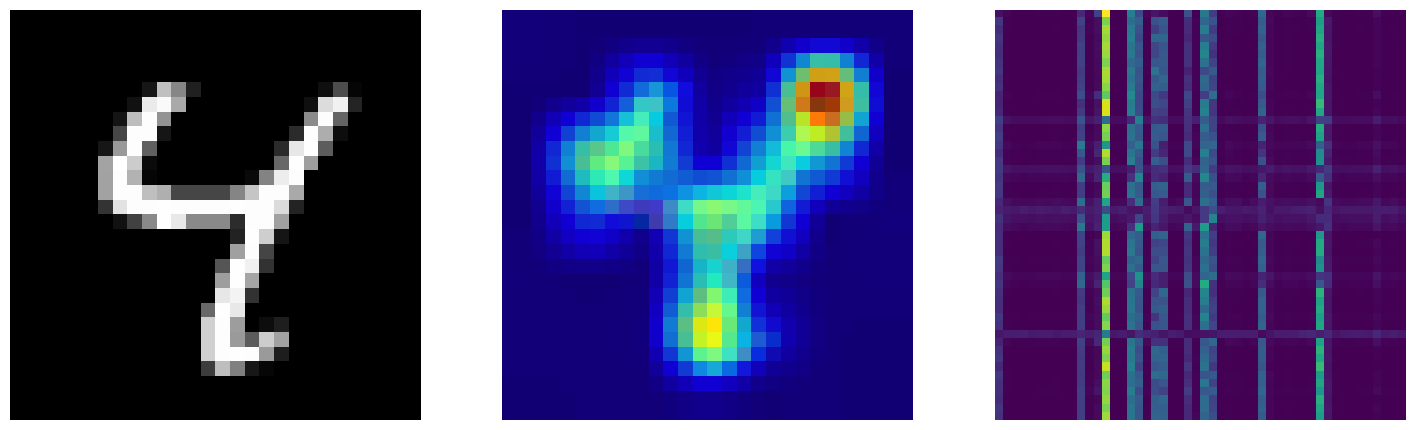

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(raw_image, alpha=1, cmap='gray')
axes[0].axis('off')

axes[1].imshow(raw_image, alpha=1)
axes[1].imshow(attn_map, alpha=0.75, cmap='jet')
axes[1].axis('off')

axes[2].imshow(attn_score)
axes[2].axis('off')